<a href="https://colab.research.google.com/github/CMDTausif/Text-Summarization-Using-Deep-learning-Approach-in-PyTorch/blob/main/Pytorch_Text_summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!nvidia-smi

Fri Apr  1 13:44:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
!pip install --quiet transformers==4.5.0
!pip install --quiet pytorch-lightning==1.2.7

     |████████████████████████████████| 2.1 MB 12.2 MB/s 
     |████████████████████████████████| 3.3 MB 42.4 MB/s 
     |████████████████████████████████| 895 kB 37.4 MB/s 
     |████████████████████████████████| 830 kB 12.3 MB/s 
     |████████████████████████████████| 136 kB 52.0 MB/s 
     |████████████████████████████████| 596 kB 7.8 MB/s 
     |████████████████████████████████| 829 kB 13.3 MB/s 
     |████████████████████████████████| 398 kB 19.1 MB/s 
     |████████████████████████████████| 1.1 MB 41.1 MB/s 
     |████████████████████████████████| 271 kB 50.9 MB/s 
     |████████████████████████████████| 144 kB 39.4 MB/s 
     |████████████████████████████████| 94 kB 3.2 MB/s 


In [2]:
from google.colab import drive

In [3]:
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
# The projects Folder
%cd /gdrive/'My Drive'/Text_Summarization

/gdrive/My Drive/Text_Summarization


In [5]:
import json
import pandas as pd
import numpy as np
import torch
torch.cuda.empty_cache()
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from termcolor import colored
import textwrap

from transformers import (
    AdamW, 
    T5ForConditionalGeneration, 
    T5TokenizerFast as T5Tokenizer )

# from transformers import AdamW, T5ForConditionalGeneration
# from transformers import T5TokenizerFast as T5Tokenizer

from tqdm.auto import tqdm

In [6]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 16, 10

In [7]:
pl.seed_everything(42)

Global seed set to 42


42

In [8]:
df = pd.read_csv("news_summary.csv", encoding='latin-1')

In [9]:
df.head()

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS...,http://www.hindustantimes.com/patna/bihar-igim...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before be...,http://indiatoday.intoday.in/story/abu-dujana-...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of s...,http://indiatoday.intoday.in/story/sex-traffic...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [10]:
df = df[['text', 'ctext']]
df.head()

,text,ctext
0,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [11]:
df.columns = ['summary', 'text']
df = df.dropna()
df.head()

,summary,text
0,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [12]:
df.shape

(4396, 2)

In [13]:
train_df, test_df = train_test_split(df, test_size=0.1)
train_df.shape, test_df.shape

((3956, 2), (440, 2))

In [14]:
class NewsSummaryDataset(Dataset):
    def __init__(
        self, 
        data: pd.DataFrame,
        tokenizer: T5Tokenizer,
        text_max_token_len: int = 512,
        summary_max_token_len: int = 128
        
    ):
        self.tokenizer = tokenizer
        self.data = data
        self.text_max_token_len = text_max_token_len
        self.summary_max_token_len = summary_max_token_len
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index:int):
        data_row = self.data.iloc[index]
        
        text = data_row['text']
        
        text_encoding = tokenizer(
            text,
            max_length = self.text_max_token_len,
            padding = 'max_length',
            truncation = True,
            return_attention_mask = True,
            add_special_tokens = True,
            return_tensors = "pt"
        )
        
        summary_encoding = tokenizer(
            data_row["summary"],
            max_length = self.text_max_token_len,
            padding = 'max_length',
            truncation = True,
            return_attention_mask = True,
            add_special_tokens = True,
            return_tensors = "pt"  # pt stands for pytorch
        )
        
        #creating labels
        labels = summary_encoding['input_ids']
        labels[labels==0] = -100
        
        return dict(
            text = text,
            summary = data_row["summary"],
            text_input_ids = text_encoding["input_ids"].flatten(),
            text_attention_mask = text_encoding["attention_mask"].flatten(),
            labels = labels.flatten(),
            labels_attention_mask = summary_encoding["attention_mask"].flatten()
        )

In [16]:
class NewsSummaryDatasetModule(pl.LightningDataModule):
    
    def __init__(
        
        self,
        train_df: pd.DataFrame,
        test_df: pd.DataFrame,
        tokenizer: T5Tokenizer,
        batch_size: int = 8,
        text_max_token_length: int= 512,
        summary_max_token_len: int= 128
    ):
        
        
        super().__init__()
        
        self.train_df = train_df
        self.test_df = test_df
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.text_max_token_length = text_max_token_length
        self.summary_max_token_len = summary_max_token_len
            
    def setup(self, stage=None):
        self.train_dataset = NewsSummaryDataset(
            self.train_df,
            self.tokenizer,
            self.text_max_token_length,
            self.summary_max_token_len
        
        )
        
        self.test_dataset = NewsSummaryDataset(
            self.test_df,
            self.tokenizer,
            self.text_max_token_length,
            self.summary_max_token_len
        
        )
        
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size = self.batch_size,
            shuffle = True,
            num_workers = 0
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = self.batch_size,
            shuffle = False,
            num_workers = 0
        )
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = self.batch_size,
            shuffle = False,
            num_workers = 0
        )
    
    

In [17]:
MODEL_NAME = "t5-base"
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [18]:
# no. of token needs to train those models

text_token_counts, summary_token_counts = [], []

for _, row in train_df.iterrows():  ## iterating over the training dataset
    text_token_count = len(tokenizer.encode(row["text"]))
    text_token_counts.append(text_token_count)
    
    summary_token_count = len(tokenizer.encode(row["summary"]))
    summary_token_counts.append(summary_token_count)

Token indices sequence length is longer than the specified maximum sequence length for this model (689 > 512). Running this sequence through the model will result in indexing errors


Text(0.5, 1.0, 'full summary token counts')

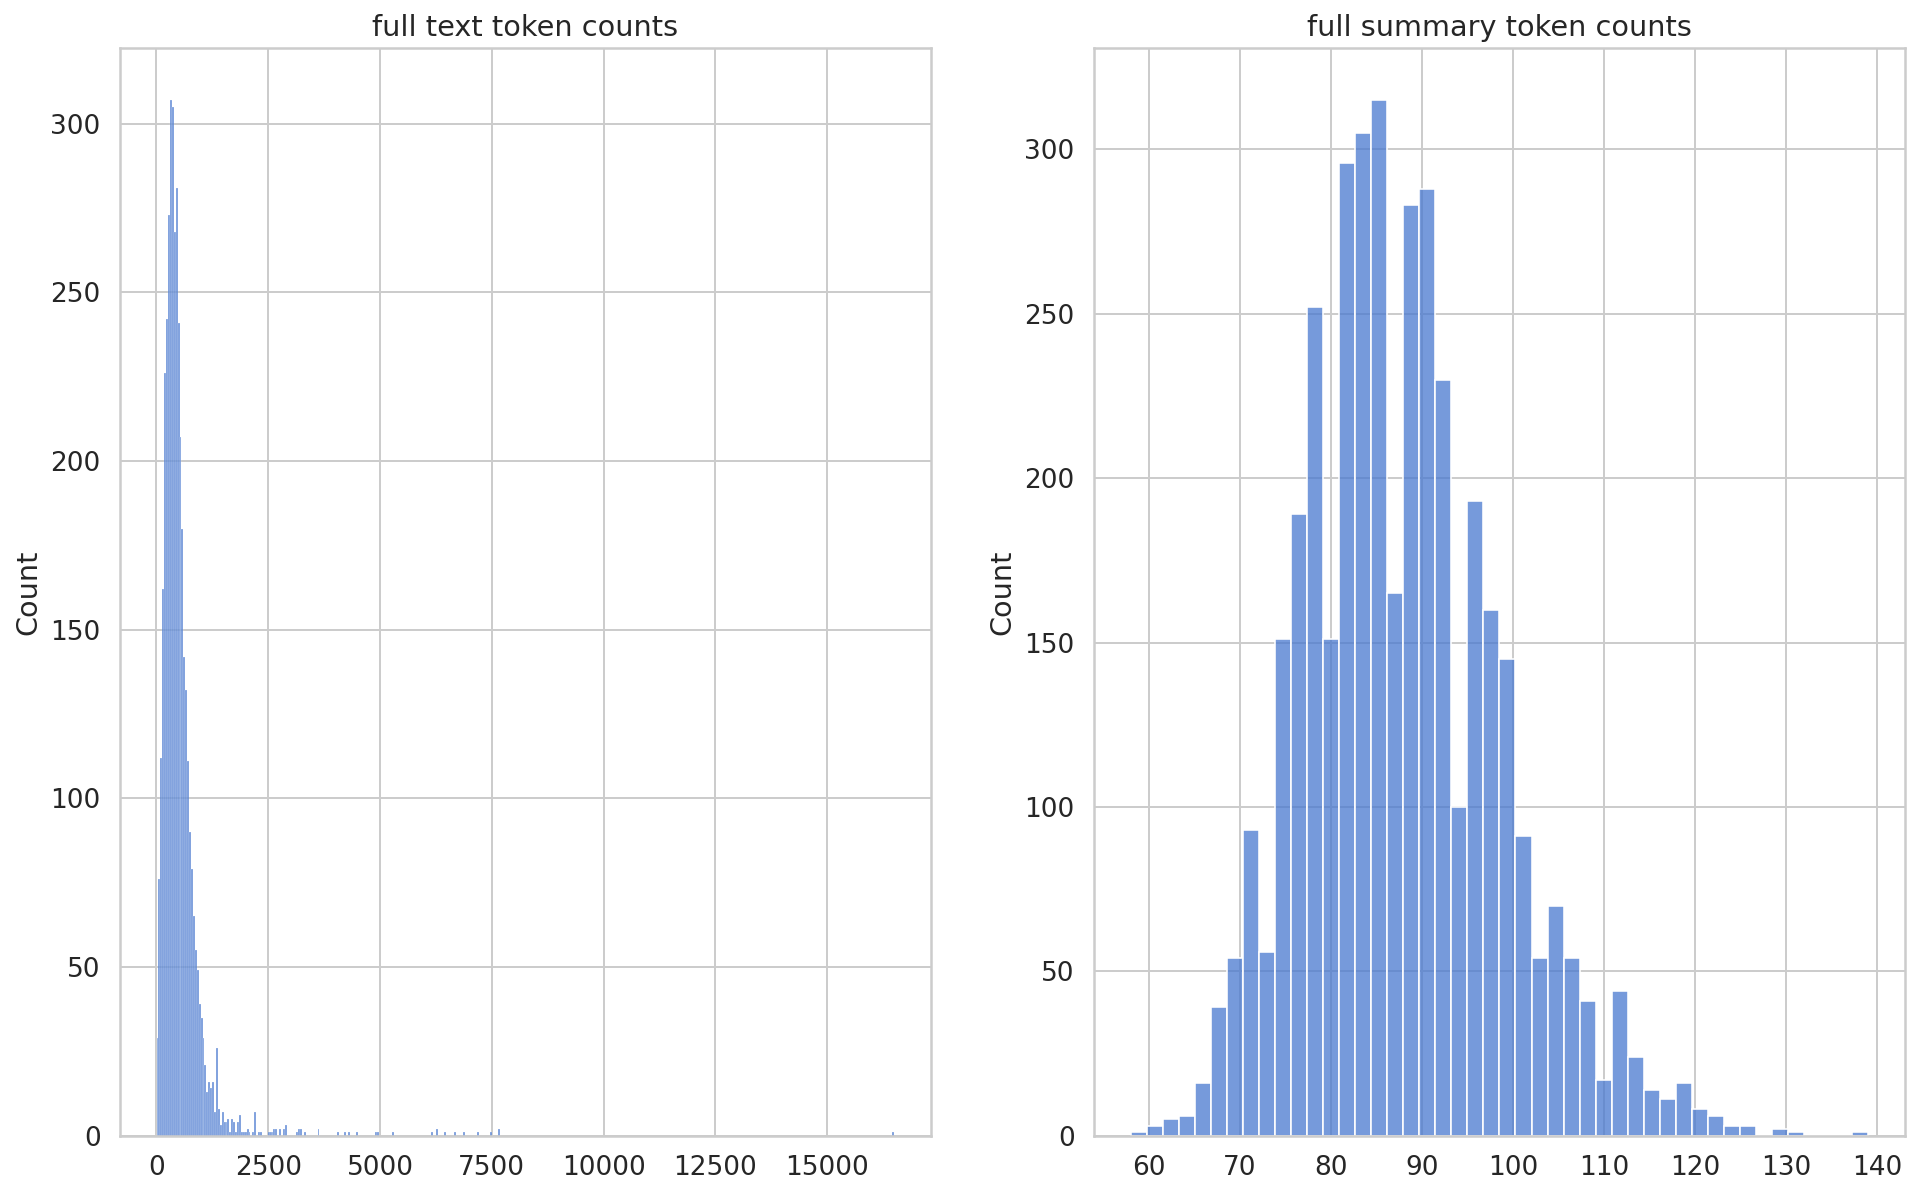

In [19]:
fig, (ax1, ax2)= plt.subplots(1, 2)

sns.histplot(text_token_counts, ax = ax1)
ax1.set_title("full text token counts")

sns.histplot(summary_token_counts, ax = ax2)
ax2.set_title("full summary token counts")

In [20]:
n_epochs = 3
Batch_Size = 4

data_module = NewsSummaryDatasetModule(train_df, test_df, tokenizer, batch_size= Batch_Size)

In [21]:
class NewsSummaryModel(pl.LightningModule):
    
    def __init__(self):
        
        super().__init__()
        self.model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict= True)
        
        
    def forward(self, input_ids, attention_mask, decoder_attention_mask, labels= None):
        
        output = self.model(
            input_ids,
            attention_mask = attention_mask,
            labels = labels,
            decoder_attention_mask = decoder_attention_mask
        
        
        )
        
        return output.loss, output.logits
    
    def training_step(self, batch, batch_idx):
        input_ids = batch["text_input_ids"]
        attention_mask = batch["text_attention_mask"]
        labels = batch["labels"]
        labels_attention_mask = batch["labels_attention_mask"]
        
        loss, outputs = self(            
            input_ids = input_ids,
            attention_mask =attention_mask,
            decoder_attention_mask = labels_attention_mask,
            labels = labels           
        )
        
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss
    
    
    
    def validation_step(self, batch, batch_idx):
        input_ids = batch["text_input_ids"]
        attention_mask = batch["text_attention_mask"]
        labels = batch["labels"]
        labels_attention_mask = batch["labels_attention_mask"]
        
        loss, outputs = self(            
            input_ids = input_ids,
            attention_mask =attention_mask,
            decoder_attention_mask = labels_attention_mask,
            labels = labels           
        )
        
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss
    
    
    def test_step(self, batch, batch_idx):
        input_ids = batch["text_input_ids"]
        attention_mask = batch["text_attention_mask"]
        labels = batch["labels"]
        labels_attention_mask = batch["labels_attention_mask"]
        
        loss, outputs = self(            
            input_ids = input_ids,
            attention_mask =attention_mask,
            decoder_attention_mask = labels_attention_mask,
            labels = labels           
        )
        
        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss
    
    def configure_optimizers(self):
        return AdamW(self.parameters(), lr= 0.0001)
    
            

In [22]:
model = NewsSummaryModel()

Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/892M [00:00<?, ?B/s]

In [23]:
# creating call backs for the checkpoints
checkpoint_callbacks = ModelCheckpoint(

    dirpath= "checkpoints",
    filename= "best-checkpoints",
    save_top_k= 1,
    verbose= True,
    monitor= "val_loss",
    mode= "min"

)

# creating a logger
logger = TensorBoardLogger("lightning_logs", name="news-summary")


## creating a trainer and passing the logger into it

trainer = pl.Trainer(

    logger= logger, # passing the logger
    checkpoint_callback= checkpoint_callbacks,
    max_epochs= n_epochs,
    gpus= 1,
    progress_bar_refresh_rate= 30


)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: Checkpoint directory checkpoints exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [24]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 0, global step 988: val_loss reached 1.46644 (best 1.46644), saving model to "/gdrive/MyDrive/Text_Summarization/checkpoints/best-checkpoints-v2.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 1977: val_loss reached 1.44953 (best 1.44953), saving model to "/gdrive/MyDrive/Text_Summarization/checkpoints/best-checkpoints-v2.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, step 2966: val_loss was not in top 1


1

In [25]:
trained_model = NewsSummaryModel.load_from_checkpoint(
    
    trainer.checkpoint_callback.best_model_path
)

trained_model.freeze()

In [31]:
def summarize(text):
  text_encoding = tokenizer(
      text,
      max_length=512,
      padding = "max_length",
      truncation =True,
      return_attention_mask = True,
      add_special_tokens = True,
      return_tensors = "pt"
  )

  generated_ids = trained_model.model.generate(
      input_ids = text_encoding["input_ids"],
      attention_mask = text_encoding["attention_mask"],
      max_length = 150,
      num_beams = 2,
      repetition_penalty = 2.5,
      length_penalty = 1.0,
      early_stopping= True
      
  )

  preds = [
  tokenizer.decode(gen_id,  skip_special_tokens=True, clean_up_tokenization_spaces= True)
  for gen_id in generated_ids
  ]

  return "".join(preds)

In [32]:
sample_row = test_df.iloc[0]
text = sample_row["text"]
model_summary = summarize(text)

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1777: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  next_indices = next_tokens // vocab_size


In [33]:
text

'Washington, Mar 27 (PTI) A 38-year-old woman in the US, who was apprehended twice for allegedly trying to jump the White House fence last week, has been arrested for scaling a fence at the Treasury Building. Marci Anderson Wahl of Everett, Washington, was arrested after an alarm sounded at about 2:15 am yesterday when she scaled a fence at the Treasury Building, next to the White House. Police said Wahl has told them she was there to speak to US President Donald Trump, the CNN reported. She was charged with unlawful entry and contempt of court. Wahl was first arrested on March 21 last week for trying to jump the White House fence. Once in custody, it was determined that Wahl had been issued a "stay away" order for the White House complex after the incident. On March 21, officers saw Wahl walking and staring at the White House complex before discovering she had jumped a fence on the south side but got stuck. Officers found her hanging from the inside of the fence by her shoelaces, whic

In [34]:
sample_row["summary"]

'A woman, who was arrested twice last week for trying to jump the White House fence, has been arrested for the third time for scaling a fence at the Treasury Building, next to the White House. The woman, who told officers that she wanted to speak to President Donald Trump, has been charged with unlawful entry and contempt of court.'

In [35]:
model_summary

'A 38-year-old woman in the US, who was apprehended twice for allegedly trying to jump the White House fence last week, has been arrested for scaling a fence at the Treasury Building. The police said that Marci Anderson Wahl had told them she was there to speak to US President Donald Trump. She was charged with unlawful entry and contempt of court.'

In [36]:
sample_row = test_df.iloc[4]
text = sample_row["text"]
model_summary = summarize(text)

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1777: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  next_indices = next_tokens // vocab_size


In [37]:
text

'Captain Amarinder Singh, the Congress\'s Chief Minister designate, will take oath as CM on March 16. The swearing-in ceremony will take place in Chandigarh on Thursday at 10 AM."A few cabinet members will also take their oath of office along with me," Amarinder said, refusing to say who will be inducted as ministers. Amarinder - accompanied by some senior Congress leaders - on Sunday went to Raj Bhawan to meet Punjab Governor V P Singh Badnore and formally staked his claim to form the next government in the state.The Governor congratulated Amarinder on the Congress\' victory and has formally invited him to form the next government in the state.\xa0RAHUL GANDHI PROPOSES AMARINDER\'S NAME AS CLP LEADEREarlier, Captain Amarinder Singh, who is the president of the Punjab Pradesh Congress Committee (PPCC), was unanimously elected the new leader of the Congress Legislative Party (CLP) in Punjab.Rahul Gandhi had proposed his name as the new CLP leader.\xa0"The election of Captain Amarinder a

In [38]:
sample_row["summary"]

'Congress leader Captain Amarinder Singh will take oath as the Chief Minister of Punjab on March 16, after he led his party to victory in the Punjab elections, winning 77 of 117 seats. Stating that Prime Minister Narendra Modi had talked to him after the election results, Singh said PM Modi promised to help him with the state.'

In [39]:
model_summary

'Congress\'s CM Amarinder Singh, who is the president of the Punjab Pradesh Congress Committee (PPCC), will take oath as CM on March 16. The swearing-in ceremony will take place in Chandigarh on Thursday. "A few cabinet members will also take their oath of office along with me," Amarinder said.'

In [44]:
sample_row = test_df.iloc[6]
text = sample_row["text"]
model_summary = summarize(text)

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1777: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  next_indices = next_tokens // vocab_size


In [45]:
text

'Mumbai, Jun 25 (PTI) Memorabilia related to cinema legend Dilip Kumar sold big at an auction here with watercolours, mixed media, portraits and collage showcard artworks of the Mughal-e-Azam topping the list of favourite items of the collectors. Dilip Kumars rare set of an original watercolour, mixed media and collage showcard artworks of "Ram Aur Shyam" that saw the actor in a first double role, sold for Rs. 3.36 lakh at Osians The Greatest Indian Show On Earth 2 - Vintage Film Memorabilia, Publicity Materials & Arts Auction on June 22. A unique 12-sheeter teaser of "Kranti" went for Rs 3 lakh. Mehboob Khans "Andaz" hoarding with Raj Kapoor-Dilip Kumar-Nargis portraits went under the hammer for Rs 1.20 lakh. A rare set of six original mixed-media collage artworks of Dilip Kumars "Mela" sold for Rs 48,000. "Aan" stills, a set of four, sold for Rs 52,800. Sepia-toned photographic stills of Sohrab Modis "Sikender" mounted on lobby cards sold for Rs 78,000. A "Kal Aaj Aur Kal" six-sheet 

In [46]:
sample_row["summary"]

"Souvenirs based on veteran actor Dilip Kumar's films were auctioned for over ?8 lakh. The highest bid was for a souvenir based on Dilip's 1967 film Ram Aur Shyam while a 12-sheeter teaser of Kranti (1981) was auctioned for ?3 lakh. Other souvenirs which were auctioned included an Aamir Khan poster, depicting him as Mangal Pandey. "

In [47]:
model_summary

'Memorabilia related to Mughal-e-Azam Dilip Kumar sold for?3.36 lakh at an auction in Mumbai on June 22. A unique 12-sheeter teaser of "Kranti" went for?3 lakh, while Mehboob Khan\'s "Andaz" hoarding with Raj Kapoor-Dilip Kumar-Nargis portraits went under the hammer for?1.20 lakh.'